In [37]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from keras import Sequential, Input
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

In [38]:
max_sequence_length = 100
experiment_name = 'uf_widernet'

In [39]:
checkpoint_path = f'saves/rnn/{max_sequence_length}_{experiment_name}'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

load data from csv

In [41]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes/'

data = []

labels = None
labels_cardinality = set()

count_files_read = 0
count_sequences_split = 0
count_splits = 0

distinct_event_types = {}
distinct_users = {}
distinct_filetypes = {}

def parse_line(line):
    event, user, filetype1, filetype2 = line.strip().split(',')
    # vectorize
    event = distinct_event_types.setdefault(event, len(distinct_event_types))
    user = distinct_users.setdefault(user, len(distinct_users))
    filetype1 = distinct_filetypes.setdefault(filetype1, len(distinct_filetypes))
    filetype2 = distinct_filetypes.setdefault(filetype2, len(distinct_filetypes))
    return event, user, filetype1, filetype2

for file_name in os.listdir(data_directory):
    count_files_read += 1
    if count_files_read % 50000 == 0:
        print(f'Loaded {count_files_read} sequences')
    with open(data_directory + file_name, 'r') as f:
        if file_name.count('_') == 2:
            label, _, _ = file_name.split('_')
        elif file_name.count('_') == 3:
            # pwd_mkdb
            label, tmp, _, _ = file_name.split('_')
            label += '_' + tmp
        else:
            print(f'Unknown file name format: {file_name}')
        labels_cardinality.add(label)

        lines = f.readlines()
        # if sequence is longer than max_sequence_length, split into multiple sequences
        if len(lines) > max_sequence_length:
            count_sequences_split += 1
            for i in range(0, len(lines), max_sequence_length):
                count_splits += 1
                datapoints = []
                for line in lines[i:i+max_sequence_length]:
                    event, user, filetype1, filetype2 = parse_line(line)
                    datapoints.append((event, user, filetype1, filetype2))
                data.append((label, datapoints))
        else:
            datapoints = []
            for line in lines:
                event, user, filetype1, filetype2 = parse_line(line)
                datapoints.append((event, user, filetype1, filetype2))
            data.append((label, datapoints))


print(f'Loaded {count_files_read} sequences (files)')
print(f'Split {count_sequences_split} sequences into {count_splits} datapoints')
print(f'Loaded {len(data)} datapoints')

labels = [ x[0] for x in data ]
data = [ x[1] for x in data ]

labels_cardinality = len(labels_cardinality)

Loaded 50000 sequences
Loaded 100000 sequences
Loaded 150000 sequences
Loaded 200000 sequences
Loaded 215150 sequences (files)
Split 22952 sequences into 156992 datapoints
Loaded 349190 datapoints


In [42]:
# get info about the classes
print(f'Found {labels_cardinality} classes')
print(f'Classes: {np.unique(labels)}')
print(f'len(data): {len(data)}, len(labels): {len(labels)}')

# removes classes with less than unusable_threshold samples
samples_before = len(data)

unusable_threshold = 10

# identify unusable classes
unusable_classes = []
for label, count in Counter(labels).items():
    if count < unusable_threshold:
        unusable_classes.append(label)

print(f'Found {len(unusable_classes)} unusable classes with less than {unusable_threshold} samples')
print(f'Unusable classes: {unusable_classes}')

# remove unusable classes from labels/data
data = [ (label, sequence) for label, sequence in zip(labels, data) if label not in unusable_classes ]
labels = [ label for label, _ in data ]
data = [ sequence for _, sequence in data ]

samples_after = len(data)
print(f'Removed {samples_before - samples_after} samples with unusable classes')
print(f'Left with {samples_after} samples, unusable classes made up {(100 * (samples_before - samples_after) / samples_before):.2f}% of the data')


print(f'len(data): {len(data)}, len(labels): {len(labels)}')

# update labels_cardinality
labels_cardinality = len(np.unique(labels))
print(f'Updated labels_cardinality to {labels_cardinality}')

Found 118 classes
Classes: ['XIM' 'adjkerntz' 'alpine' 'anvil' 'atrun' 'awk' 'basename' 'bash'
 'bounce' 'bzcat' 'bzip2' 'cat' 'chkgrp' 'chown' 'cleanup' 'cmp' 'cp'
 'cron' 'csh' 'cut' 'date' 'dd' 'devd' 'df' 'dhclient' 'diff' 'dmesg'
 'egrep' 'env' 'expr' 'find' 'fortune' 'getty' 'grep' 'head' 'hostname'
 'id' 'ifconfig' 'imapd' 'inetd' 'init' 'ipfstat' 'ipfw' 'jot' 'kenv'
 'kill' 'kldstat' 'less' 'limits' 'links' 'local' 'locale' 'lockf' 'ls'
 'lsof' 'mail' 'mailwrapper' 'master' 'minions' 'mkdir' 'mktemp' 'mlock'
 'mount' 'msgs' 'mv' 'nawk' 'netstat' 'newsyslog' 'nginx' 'nice' 'nohup'
 'pfctl' 'php-fpm' 'pickup' 'ping' 'pkg' 'postmap' 'proxymap' 'ps' 'pw'
 'pwd_mkdb' 'python2.7' 'resizewin' 'rm' 'route' 'screen' 'sed' 'sendmail'
 'sh' 'sleep' 'smtp' 'smtpd' 'sort' 'ssh' 'sshd' 'stat' 'stty' 'su' 'sudo'
 'sysctl' 'tail' 'tee' 'test' 'top' 'touch' 'tr' 'trivial-rewrite' 'tty'
 'uname' 'uniq' 'unlink' 'uptime' 'vi' 'vmstat' 'wc' 'wget' 'which' 'xz']
len(data): 349190, len(labels): 3491

In [43]:
# vectorize labels
label_mapping = { label: i for i, label in enumerate(np.unique(labels)) }
label_mapping_reverse = { i: label for i, label in enumerate(np.unique(labels)) }

labels = [ label_mapping[label] for label in labels ]

In [44]:
print(label_mapping)
print(label_mapping_reverse)

{'adjkerntz': 0, 'alpine': 1, 'anvil': 2, 'atrun': 3, 'awk': 4, 'basename': 5, 'bash': 6, 'bounce': 7, 'bzcat': 8, 'bzip2': 9, 'cat': 10, 'cleanup': 11, 'cmp': 12, 'cp': 13, 'cron': 14, 'csh': 15, 'date': 16, 'dd': 17, 'devd': 18, 'dhclient': 19, 'dmesg': 20, 'egrep': 21, 'expr': 22, 'find': 23, 'fortune': 24, 'grep': 25, 'head': 26, 'hostname': 27, 'imapd': 28, 'inetd': 29, 'kill': 30, 'less': 31, 'local': 32, 'lockf': 33, 'ls': 34, 'lsof': 35, 'mail': 36, 'mailwrapper': 37, 'master': 38, 'mkdir': 39, 'mktemp': 40, 'mlock': 41, 'mount': 42, 'mv': 43, 'netstat': 44, 'newsyslog': 45, 'nginx': 46, 'php-fpm': 47, 'pickup': 48, 'pkg': 49, 'postmap': 50, 'proxymap': 51, 'ps': 52, 'python2.7': 53, 'resizewin': 54, 'rm': 55, 'route': 56, 'screen': 57, 'sed': 58, 'sendmail': 59, 'sh': 60, 'sleep': 61, 'smtp': 62, 'smtpd': 63, 'sort': 64, 'sshd': 65, 'su': 66, 'sudo': 67, 'sysctl': 68, 'tail': 69, 'tee': 70, 'top': 71, 'trivial-rewrite': 72, 'tty': 73, 'unlink': 74, 'uptime': 75, 'vi': 76, 'vms

In [45]:
event_type_vectorized_to_string = { v: k for k, v in distinct_event_types.items() }
user_vectorized_to_string = { v: k for k, v in distinct_users.items() }
filetype_vectorized_to_string = { v: k for k, v in distinct_filetypes.items() }

In [46]:
print(event_type_vectorized_to_string)
print(user_vectorized_to_string)
print(filetype_vectorized_to_string)

{0: 'EVENT_CLOSE', 1: 'EVENT_EXECUTE', 2: 'EVENT_OPEN', 3: 'EVENT_READ', 4: 'EVENT_MMAP', 5: 'EVENT_EXIT', 6: 'EVENT_CHANGE_PRINCIPAL', 7: 'EVENT_MODIFY_PROCESS', 8: 'EVENT_WRITE', 9: 'EVENT_FCNTL', 10: 'EVENT_LSEEK', 11: 'EVENT_LOGIN', 12: 'EVENT_CONNECT', 13: 'EVENT_SENDTO', 14: 'EVENT_RECVFROM', 15: 'EVENT_MODIFY_FILE_ATTRIBUTES', 16: 'EVENT_CREATE_OBJECT', 17: 'EVENT_FORK', 18: 'EVENT_TRUNCATE', 19: 'EVENT_UNLINK', 20: 'EVENT_MPROTECT', 21: 'EVENT_OTHER', 22: 'EVENT_SENDMSG', 23: 'EVENT_ACCEPT', 24: 'EVENT_LINK', 25: 'EVENT_RENAME', 26: 'EVENT_RECVMSG', 27: 'EVENT_SIGNAL', 28: 'EVENT_BIND'}
{0: 'darpa', 1: 'root', 2: 'george', 3: 'operator', 4: 'user', 5: 'bob', 6: 'frank', 7: 'henry', 8: 'admin', 9: 'charles', 10: 'smmsp', 11: 'david', 12: 'irene', 13: 'postfix', 14: 'www', 15: 'nobody', 16: '_dhcp'}
{0: 'FILE_OBJECT_FILE', 1: 'None', 2: 'SUBJECT_PROCESS', 3: 'FILE_OBJECT_DIR', 4: 'UNNAMEDPIPE', 5: 'FILE_OBJECT_UNIX_SOCKET', 6: 'NETFLOW'}


In [47]:
# separate features, encode
# turn dicts into lists
distinct_event_types = list(distinct_event_types.keys())
distinct_users = list(distinct_users.keys())
distinct_filetypes = list(distinct_filetypes.keys())

event_type_cardinality = len(distinct_event_types)
user_cardinality = len(distinct_users)
filetype_cardinality = len(distinct_filetypes)

print(f'len(data): {len(data)}, len(labels): {len(labels)}')

print(f'found {event_type_cardinality} distinct event types')
print(f'event types: {distinct_event_types}')
print(f'found {user_cardinality} distinct users')
print(f'users: {distinct_users}')
print(f'found {filetype_cardinality} distinct filetypes')
print(f'filetypes: {distinct_filetypes}')

event_type_data = []
user_data = []
filetype_1_data = []
filetype_2_data = []

for sequence in data:
    event_types = [ x[0] for x in sequence ]
    users = [ x[1] for x in sequence ]
    filetypes_1 = [ x[2] for x in sequence ]
    filetypes_2 = [ x[3] for x in sequence ]

    # one-hot encode
    event_types = np.eye(event_type_cardinality)[event_types]
    users = np.eye(user_cardinality)[users]
    filetypes_1 = np.eye(filetype_cardinality)[filetypes_1]
    filetypes_2 = np.eye(filetype_cardinality)[filetypes_2]

    event_type_data.append(event_types)
    user_data.append(users)
    filetype_1_data.append(filetypes_1)
    filetype_2_data.append(filetypes_2)

print(f'encoded features to one-hot')

# combine features back together
data = [ np.hstack((event_type_data[i], user_data[i], filetype_1_data[i], filetype_2_data[i])) for i in range(len(data)) ]
print(f'combined features back together')

feature_vector_cardinality = data[0].shape[1]
print(f'resulting feature vector cardinality: {feature_vector_cardinality}')

print(f'len(data): {len(data)}, len(labels): {len(labels)}')


len(data): 349058, len(labels): 349058
found 29 distinct event types
event types: ['EVENT_CLOSE', 'EVENT_EXECUTE', 'EVENT_OPEN', 'EVENT_READ', 'EVENT_MMAP', 'EVENT_EXIT', 'EVENT_CHANGE_PRINCIPAL', 'EVENT_MODIFY_PROCESS', 'EVENT_WRITE', 'EVENT_FCNTL', 'EVENT_LSEEK', 'EVENT_LOGIN', 'EVENT_CONNECT', 'EVENT_SENDTO', 'EVENT_RECVFROM', 'EVENT_MODIFY_FILE_ATTRIBUTES', 'EVENT_CREATE_OBJECT', 'EVENT_FORK', 'EVENT_TRUNCATE', 'EVENT_UNLINK', 'EVENT_MPROTECT', 'EVENT_OTHER', 'EVENT_SENDMSG', 'EVENT_ACCEPT', 'EVENT_LINK', 'EVENT_RENAME', 'EVENT_RECVMSG', 'EVENT_SIGNAL', 'EVENT_BIND']
found 17 distinct users
users: ['darpa', 'root', 'george', 'operator', 'user', 'bob', 'frank', 'henry', 'admin', 'charles', 'smmsp', 'david', 'irene', 'postfix', 'www', 'nobody', '_dhcp']
found 7 distinct filetypes
filetypes: ['FILE_OBJECT_FILE', 'None', 'SUBJECT_PROCESS', 'FILE_OBJECT_DIR', 'UNNAMEDPIPE', 'FILE_OBJECT_UNIX_SOCKET', 'NETFLOW']
encoded features to one-hot
combined features back together
resulting featur

In [48]:
# statified split 
# duplicates classes with less than rare_threshold samples in training set

rare_threshold = 50

# identify rare classes
rare_classes = []
for label, count in Counter(labels).items():
    if count < rare_threshold:
        rare_classes.append(label)

print(f'Found {len(rare_classes)} rare classes with less than {rare_threshold} samples to oversample')
# print rare classes (decoded)
print(f'Rare classes: { [ label_mapping_reverse[label] for label in rare_classes ] }')


# split into training, validation and testing (70/15/15) using stratified split
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

print(f'split data into training, validation and testing sets')
print(f'training set size: {len(X_train)}')
print(f'validation set size: {len(X_val)}')
print(f'testing set size: {len(X_test)}')

print(f'oversampling rare classes in training set until they make up 5% of the set')

# separate rare classes from training set
rare_data = []
rare_labels = []
for i, label in enumerate(y_train):
    if label in rare_classes:
        rare_data.append(X_train[i])
        rare_labels.append(label)

X_train = [x for x, y in zip(X_train, y_train) if not np.isin(y, rare_classes)]
y_train = [y for y in y_train if y not in rare_classes]


print(f'removed {len(rare_data)} rare samples from training set')
print(f'training set size: {len(X_train)}')


# duplicate rare classes 25x
for i in range(25):
    X_train.extend(rare_data)
    y_train.extend(rare_labels)

print(f'oversampled rare classes until they made up 5% of the training set')


print(f'Training on {len(X_train)} samples')
print(f'Validating on {len(X_val)} samples')
print(f'Testing on {len(X_test)} samples')

print(f'total samples: {len(X_train) + len(X_val) + len(X_test)}')

# check how many labels are not present in sets
train_labels = set(y_train)
val_labels = set(y_val)
test_labels = set(y_test)

total_labels = set(range(labels_cardinality))

# print which labels do not occur in which set
print(f'Labels not in training: {[ label_mapping_reverse[label] for label in (total_labels - train_labels)]}')
print(f'Labels not in validation: {[ label_mapping_reverse[label] for label in (total_labels - val_labels)]}')
print(f'Labels not in testing: {[ label_mapping_reverse[label] for label in (total_labels - test_labels)]}')

# one-hot encode labels
y_train = np.eye(labels_cardinality)[y_train]
y_val = np.eye(labels_cardinality)[y_val]
y_test = np.eye(labels_cardinality)[y_test]

# shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

Found 30 rare classes with less than 50 samples to oversample
Rare classes: ['wc', 'grep', 'vi', 'mktemp', 'less', 'tty', 'mailwrapper', 'kill', 'lockf', 'bzip2', 'mount', 'tee', 'expr', 'ps', 'bzcat', 'nginx', 'route', 'sed', 'smtp', 'cmp', 'php-fpm', 'egrep', 'bounce', 'sort', 'basename', 'awk', 'csh', 'su', 'mail', 'postmap']
split data into training, validation and testing sets
training set size: 244340
validation set size: 52359
testing set size: 52359
oversampling rare classes in training set until they make up 5% of the set
removed 485 rare samples from training set
training set size: 243855
oversampled rare classes until they made up 5% of the training set
Training on 255980 samples
Validating on 52359 samples
Testing on 52359 samples
total samples: 360698
Labels not in training: []
Labels not in validation: []
Labels not in testing: []


training set distribution: Counter({'bash': 58678, 'lsof': 40046, 'sleep': 22814, 'python2.7': 19794, 'vmstat': 11516, 'imapd': 10788, 'sh': 9263, 'top': 8931, 'find': 8607, 'head': 5687, 'date': 5686, 'local': 4213, 'mv': 4015, 'master': 3490, 'smtpd': 3489, 'pkg': 3484, 'cron': 2928, 'mlock': 2362, 'sshd': 1959, 'trivial-rewrite': 1833, 'alpine': 1655, 'inetd': 1387, 'proxymap': 1366, 'cleanup': 1301, 'anvil': 1183, 'atrun': 1107, 'route': 850, 'wc': 825, 'grep': 775, 'mktemp': 775, 'wget': 702, 'tee': 700, 'ps': 675, 'less': 650, 'pickup': 638, 'sysctl': 601, 'dd': 582, 'unlink': 575, 'cmp': 550, 'awk': 525, 'nginx': 500, 'fortune': 426, 'lockf': 425, 'php-fpm': 425, 'resizewin': 421, 'mailwrapper': 375, 'sed': 375, 'bzcat': 350, 'xz': 343, 'vi': 275, 'netstat': 259, 'postmap': 250, 'egrep': 250, 'tty': 250, 'expr': 250, 'dhclient': 244, 'screen': 233, 'bounce': 225, 'mount': 225, 'csh': 225, 'smtp': 225, 'mail': 200, 'kill': 200, 'su': 200, 'basename': 200, 'sort': 200, 'rm': 181, 

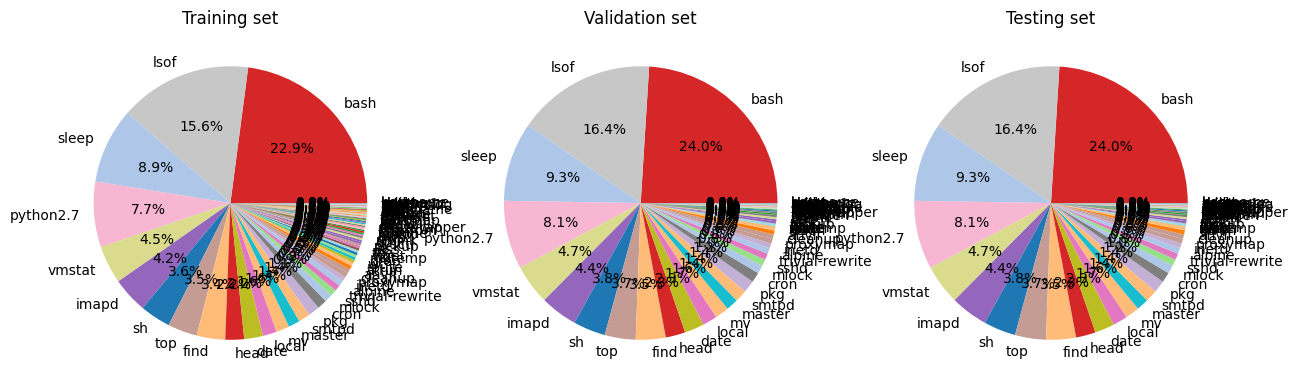

In [49]:
# plot class distribution in all 3 sets

train_distribution = Counter([ label_mapping_reverse[np.argmax(y)] for y in y_train ])
val_distribution = Counter([ label_mapping_reverse[np.argmax(y)] for y in y_val ])
test_distribution = Counter([ label_mapping_reverse[np.argmax(y)] for y in y_test ])

print(f'training set distribution: {train_distribution}')
print(f'validation set distribution: {val_distribution}')
print(f'testing set distribution: {test_distribution}')

# plot 3 pie plots, use same colors for same classes
# get colors

colors = plt.cm.tab20.colors
colors = [ colors[i % 20] for i in range(labels_cardinality) ]

# sort by occurence in training set
sorted_labels = sorted(train_distribution.keys(), key=lambda x: train_distribution[x], reverse=True)

train_sizes = [ train_distribution[label] for label in sorted_labels ]
val_sizes = [ val_distribution[label] for label in sorted_labels ]
test_sizes = [ test_distribution[label] for label in sorted_labels ]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].pie(train_sizes, labels=sorted_labels, autopct='%1.1f%%', colors=[colors[label_mapping[label]] for label in sorted_labels])
axs[0].set_title('Training set')

axs[1].pie(val_sizes, labels=sorted_labels, autopct='%1.1f%%', colors=[colors[label_mapping[label]] for label in sorted_labels])
axs[1].set_title('Validation set')

axs[2].pie(test_sizes, labels=sorted_labels, autopct='%1.1f%%', colors=[colors[label_mapping[label]] for label in sorted_labels])
axs[2].set_title('Testing set')

plt.show()

In [50]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, fixed_length, **kwargs):
        # valid **kwargs: workers, use_multiprocessing, max_queue_size
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.fixed_length = fixed_length
        self.no_samples = len(X)
        self.no_batches = int(np.ceil(self.no_samples / self.batch_size))

    def __len__(self):
        return self.no_batches

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, self.no_samples)

        # Get the batch data
        X_batch = self.X[start:end]
        y_batch = self.y[start:end]

        # Pad or truncate each sequence in X_batch to the fixed length
        X_batch_fixed = [self._pad_or_truncate(x, self.fixed_length) for x in X_batch]

        # Convert to numpy arrays
        X_batch_fixed = np.array(X_batch_fixed)
        y_batch = np.array(y_batch)

        return X_batch_fixed, y_batch

    def _pad_or_truncate(self, sequence, length):
        return np.pad(sequence, ((0, length - len(sequence)), (0, 0)), mode='constant', constant_values=0)

    def on_epoch_end(self):
        pass

build model

In [51]:
model = Sequential(layers=[
    Input(shape=(None, feature_vector_cardinality)),
    SimpleRNN(96, return_sequences=True),
    SimpleRNN(96, return_sequences=True),
    SimpleRNN(96, return_sequences=True),
    SimpleRNN(96, return_sequences=True),
    SimpleRNN(96, return_sequences=False),
    Dense(labels_cardinality, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 96)       │        15,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 96)       │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, None, 96)       │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, None, 96)       │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 81)             │         7,857 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,041 (379.07 KB)

 Trainable params: 97,041 (379.07 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto'
)

model_checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-7
)

csv_logger = CSVLogger(
    filename=log_path,
    append=True
)

optimizer = Adam(learning_rate=0.0001)


# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(optimizer=optimizer, loss='categorical_focal_crossentropy', metrics=['accuracy'])

train model

In [24]:
# load old model
model = load_model(model_path)

In [54]:
history = model.fit(
    x=Generator(X_train, y_train, 96, max_sequence_length),
    validation_data=Generator(X_val, y_val, 96, max_sequence_length),
    epochs=200,
    callbacks=[early_stop, model_checkpoint, lr_schedule, csv_logger],
)

# save history to file
with open(history_path, 'wb') as f:
    np.save(f, history.history)

Epoch 1/200
   3/2667 ━━━━━━━━━━━━━━━━━━━━ 1:52 42ms/step - accuracy: 0.0208 - loss: 1.0778 

I0000 00:00:1721984539.043309 2544507 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 56 bytes spill stores, 56 bytes spill loads



1293/2667 ━━━━━━━━━━━━━━━━━━━━ 1:02 46ms/step - accuracy: 0.7733 - loss: 0.2600

I0000 00:00:1721984597.959187 2544506 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 56 bytes spill stores, 56 bytes spill loads



2666/2667 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8336 - loss: 0.1843
Epoch 1: val_loss improved from inf to 0.02410, saving model to saves/rnn/100_uf_widernet/model.keras
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 136s 49ms/step - accuracy: 0.8336 - loss: 0.1843 - val_accuracy: 0.9629 - val_loss: 0.0241 - learning_rate: 1.0000e-04
Epoch 2/200
2666/2667 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9589 - loss: 0.0271
Epoch 2: val_loss improved from 0.02410 to 0.01516, saving model to saves/rnn/100_uf_widernet/model.keras
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 129s 48ms/step - accuracy: 0.9589 - loss: 0.0271 - val_accuracy: 0.9698 - val_loss: 0.0152 - learning_rate: 1.0000e-04
Epoch 3/200
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9676 - loss: 0.0164
Epoch 3: val_loss did not improve from 0.01516
2667/2667 ━━━━━━━━━━━━━━━━━━━━ 128s 48ms/step - accuracy: 0.9676 - loss: 0.0164 - val_accuracy: 0.9634 - val_loss: 0.0169 - learning_rate: 1.0000e-04
Epoch 4/200
2667/2667 ━━━━━━━━━━━━━━━

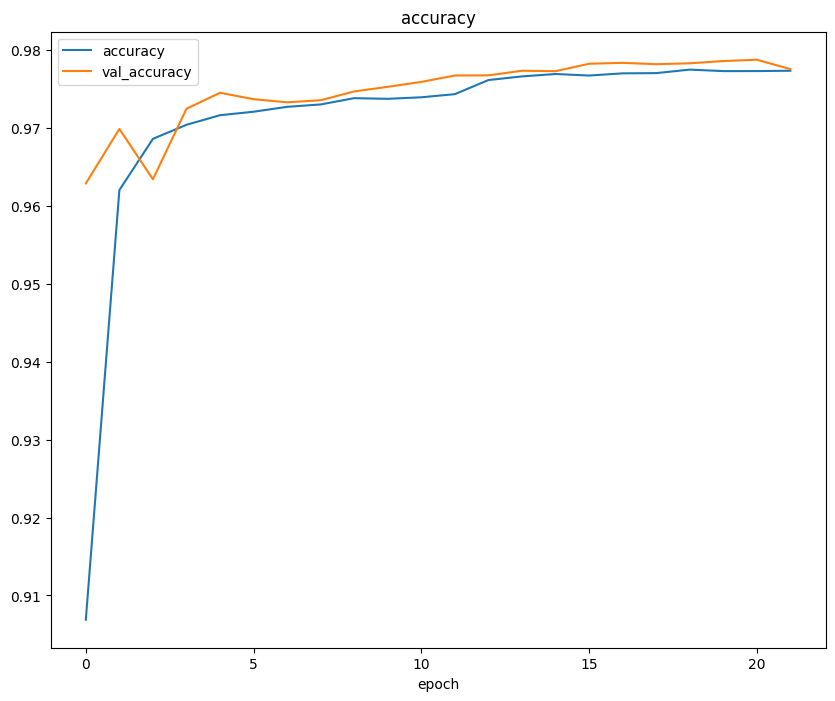

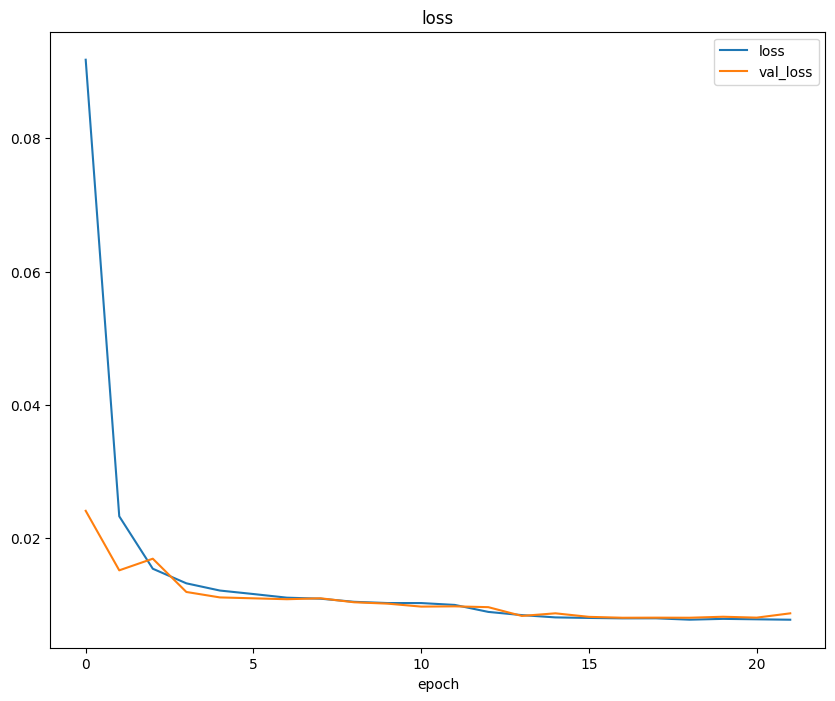

In [55]:
log = pd.read_csv(log_path)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['accuracy'], label='accuracy')
ax.plot(log['epoch'], log['val_accuracy'], label='val_accuracy')
ax.set_title('accuracy')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['loss'], label='loss')
ax.plot(log['epoch'], log['val_loss'], label='val_loss')
ax.set_title('loss')
ax.set_xlabel('epoch')
ax.legend()

plt.show()

In [56]:
# evaluate model
score = model.evaluate(x=Generator(X_test, y_test, 64, max_sequence_length))
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

819/819 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.9768 - loss: 0.0094
Test loss: 0.00919131375849247
Test accuracy: 0.9766802191734314


In [57]:
# print classification report
y_pred = model.predict(x=Generator(X_test, y_test, 64, max_sequence_length))
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

distinct_labels = [ label_mapping_reverse[i] for i in range(labels_cardinality) ]

print(classification_report(y_true, y_pred, target_names=distinct_labels, zero_division=np.nan))


819/819 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step
                 precision    recall  f1-score   support

      adjkerntz       0.00      0.00      0.00        11
         alpine       0.98      0.97      0.97       355
          anvil       0.64      0.40      0.49       253
          atrun       1.00      1.00      1.00       237
            awk       1.00      1.00      1.00         5
       basename        nan      0.00      0.00         1
           bash       1.00      1.00      1.00     12574
         bounce       1.00      0.50      0.67         2
          bzcat       0.13      1.00      0.23         3
          bzip2       0.00      0.00      0.00         2
            cat       1.00      0.88      0.94        26
        cleanup       0.90      0.45      0.60       279
            cmp       1.00      1.00      1.00         5
             cp       0.97      1.00      0.98        31
           cron       1.00      1.00      1.00       628
            csh       0.33      0.50      0.

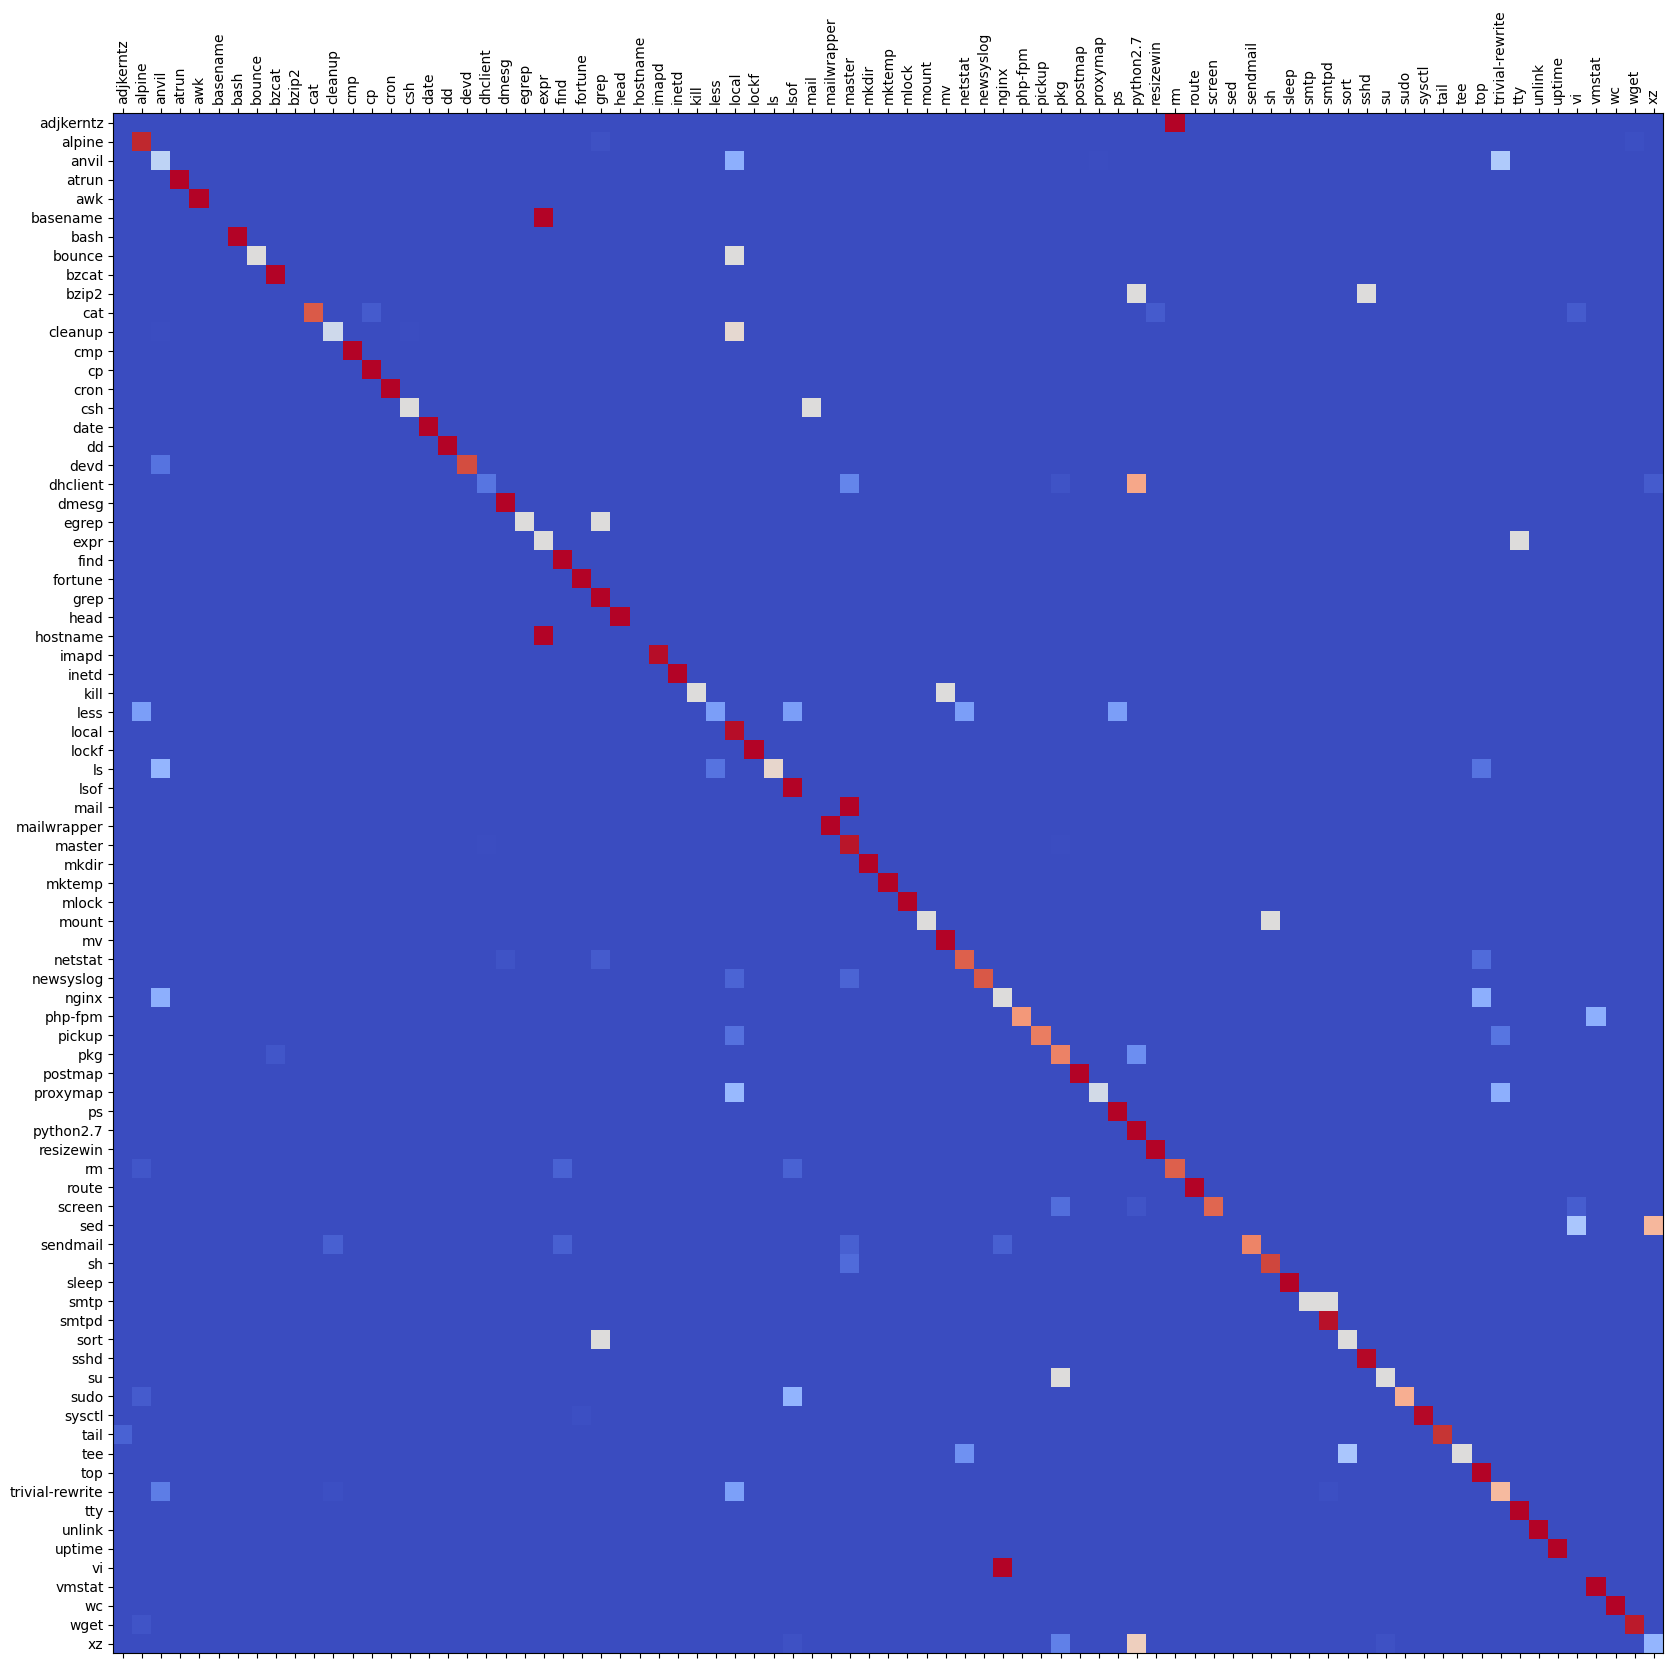

In [58]:
# print confusion matrix
# labels explicitly set, because current model may not predict all labels
cm = confusion_matrix(y_true, y_pred, labels=range(labels_cardinality))

# transform to percentage
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# replace all NaN values with 0
cm = np.nan_to_num(cm)

fig, ax = plt.subplots(figsize=(20, 20))

ax.matshow(cm, cmap='coolwarm', aspect='auto')

# Set class names on axes
ax.set_xticks(range(len(distinct_labels)))
ax.set_yticks(range(len(distinct_labels)))
ax.set_xticklabels(distinct_labels, rotation=90)
ax.set_yticklabels(distinct_labels)

plt.show()